<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#导入包" data-toc-modified-id="导入包-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>导入包</a></span></li><li><span><a href="#读取数据" data-toc-modified-id="读取数据-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>读取数据</a></span></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>baseline model</a></span></li><li><span><a href="#Transform-the-time-series-into-a-supervised-learning-problem" data-toc-modified-id="Transform-the-time-series-into-a-supervised-learning-problem-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transform the time series into a supervised learning problem</a></span></li><li><span><a href="#keras" data-toc-modified-id="keras-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>keras</a></span></li><li><span><a href="#Tensorflow" data-toc-modified-id="Tensorflow-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tensorflow</a></span><ul class="toc-item"><li><span><a href="#Making-training-mini-batches" data-toc-modified-id="Making-training-mini-batches-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Making training mini-batches</a></span></li></ul></li></ul></div>

# 导入包

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from pandas import DataFrame
from pandas import concat

import numpy

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import os
import sklearn
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd
import time
from datetime import datetime, timedelta
from tzlocal import get_localzone # $ pip install tzlocal
import math
%matplotlib inline

In [3]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


# 读取数据

In [4]:
server_ip = '111.170.234.221'
dir_path = "data/" + server_ip + "/"
files = os.listdir(dir_path)
df_arr = []
for f in files:
    if(f.find(".csv") != -1):
        day_df = pd.read_csv(dir_path + f )
        df_arr.append(day_df)
df = pd.concat(df_arr)

In [5]:
df['time'] = pd.to_datetime(df['time'],unit='s')
#timezone
df['time']=df['time']+timedelta(hours=8)

In [6]:
output_cols = ['value_a_count','value_b_count','value_c_count','all_count','reach_rate_a','reach_rate_b','reach_rate_c']
other_cols = ['time','day','server_ip']

df = df.sort_values('time')
df = df.drop("reach_rate")
df['reach_rate_a'] = df['value_a_count']/ df['all_count']
df['reach_rate_b'] = df['value_b_count']/ df['all_count']
df['reach_rate_c'] = df['value_c_count']/ df['all_count']  

In [7]:
data=np.array(df['reach_rate_c'])

In [8]:
data

array([ 0.89263421,  0.87795766,  0.87534626, ...,  0.77621692,
        0.78531599,  0.78719397])

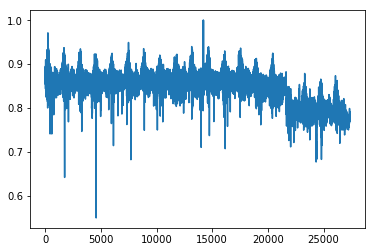

In [9]:
plt.figure()
plt.plot(data)

# baseline model 

预测用现实的时间点的前一个
,即p(t)=data(t-1)

In [ ]:
X = data
len_train=int(len(data)*2/3)
len_test=len(data)-len_train
train, test = X[0:-len_test], X[-len_test:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

# Transform the time series into a supervised learning problem

In [ ]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [ ]:
 # frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    # 把第一行去掉
    df=df.drop([0])
    #print(df)
    #df.fillna(0.89263421, inplace=True)
    return df

In [ ]:
supervised = timeseries_to_supervised(X, 1)
supervised_values = supervised.values
print("supervised_values shape: {}".format(supervised_values.shape))
# split data into train and test-sets
train, test = supervised_values[0:-len_test], supervised_values[-len_test:]
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape)) 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(scaler)

In [ ]:
plt.figure()
#plt.plot(train_scaled)
#plt.plot(test_scaled)
#第0个点被去除
plt.plot(list(range(1,len(train_scaled)+1)), train_scaled, color='b')
plt.plot(list(range(len(train_scaled)+1, len(train_scaled) + len(test_scaled)+1)), test_scaled, color='r')
plt.show()

# keras

In [ ]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print("number of samples:{}".format(X.shape[0]))
    print("number of time steps:{}".format(X.shape[1]))
    print("number of features:{}".format(X.shape[2]))
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model

In [ ]:
lstm_model = fit_lstm(train_scaled, batch_size=1, nb_epoch=2, neurons=10)

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    #lstm_model.reset_states()
    yhat = forecast_lstm(lstm_model, 1, X)
    # This should produce a model with perfect skill
    # yhat = y
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = data[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(data[-len_test:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(data[-len_test:])
pyplot.plot(predictions)
pyplot.show()

# Tensorflow

## Making training mini-batches

In [ ]:
# 压缩为 1到-1

In [44]:
data_size=data.shape[0]
train_size=int(data_size/3*2)
test_size=data_size-train_size

In [45]:
normalize_data = (data - np.mean(data)) / np.std(data)
normalize_data = normalize_data[:, np.newaxis]

In [46]:
train_data=normalize_data[0:train_size]
test_data=normalize_data[-test_size:]

In [47]:
time_step = 1
rnn_unit = 10
batch_size = 60
input_size = 1
output_size = 1
lr = 0.0006

In [48]:
train_x, train_y = [], []
for i in range(train_size - time_step - 1):
    x = train_data[i:i + time_step]
    y = train_data[i + 1:i + time_step + 1]
    train_x.append(x.tolist())
    train_y.append(y.tolist())

In [49]:
test_x, test_y = [], []
for i in range(test_size-1):
    x = test_data[i]
    y = test_data[i+1]
    test_x.append(x.tolist())
    test_y.append(y.tolist())

In [16]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

In [17]:
def build_inputs():
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    X = tf.placeholder(tf.float32, [None, time_step, input_size])
    Y = tf.placeholder(tf.float32, [None, time_step, output_size])

    return X, Y

In [18]:
def build_lstm(batch_size):
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])   
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    
    return pred,final_states

In [19]:
X,Y=build_inputs()

In [20]:
with tf.variable_scope("sec_lstm"):
    pred,_=build_lstm(batch_size)
loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
train_op=tf.train.AdamOptimizer(lr).minimize(loss)
saver=tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1): #We can increase the number of iterations to gain better result.
        step=0
        start=0
        end=start+batch_size
        while(end<len(train_x)):
            _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
            start+=batch_size
            end=start+batch_size

            if step%10==0:
                print("Number of iterations:",i," loss:",loss_)
                print("model_save",saver.save(sess,'model_save1/modle.ckpt'))
                #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
                #if you run it in Linux,please use  'model_save1/modle.ckpt'
            step+=1
    print("The train has finished")

Number of iterations: 0  loss: 0.500361
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.112126
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.0636153
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.35646
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.176088
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.544564
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.196761
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.686675
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.170086
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.105673
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.420791
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.0906182
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.185125
model_save model_save1/modle.ckpt
Number of iterations: 0  loss: 0.1294

INFO:tensorflow:Restoring parameters from model_save1/modle.ckpt


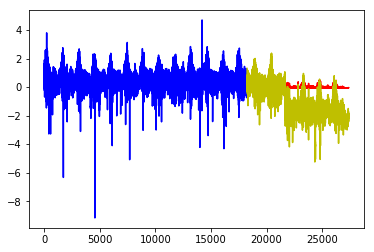

In [53]:
with tf.variable_scope("sec_lstm",reuse=True):
    pred,_=build_lstm(1)    
saver=tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    saver.restore(sess, 'model_save1/modle.ckpt')
    #I run the code in windows 10,so use  'model_save1\\modle.ckpt'
    #if you run it in Linux,please use  'model_save1/modle.ckpt'
    predict=[]
    for i in range(len(test_x)):
        next_seq=sess.run(pred,feed_dict={X:[[test_x[i]]]})
        predict.append(next_seq[-1])

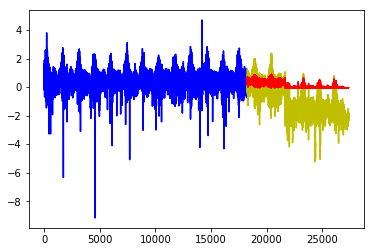

In [54]:
plt.figure()
plt.plot(list(range(len(train_data))),train_data, color='b')
plt.plot(list(range(len(train_data), len(train_data) + len(test_data))), test_data, color='y')
plt.plot(list(range(len(train_data)+1, len(train_data) + len(test_data))), predict, color='r')
plt.show()

In [35]:
2*len(predict)

18238

In [33]:
len(train_data)

18240

In [36]:
len(test_x)

9119

In [34]:
train_size

18240

In [40]:
len(test_x)

9119

In [42]:
len(test_data)

18240

In [43]:
test_size

9120